# 0. Introduction

[Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) is a competition held by well-known data science community [Kaggle](https://www.kaggle.com/).

*The sinking of the Titanic is one of the most infamous shipwrecks in history.*

*On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.*

*While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.*

*In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).*

In this legendary competition, contestants are asked to predict the survival of passengers on Titanic, this is a educational competition with no dead line and serves as a great starting point for learning data science/machine learning. Being the first and my favorite data science project, once a while when I achieved new skills, learned new models, I come back to this competition and apply them. 

Recently, I visited the discussion section of this competition and found many people novice to the field suffering on how to improve their prediction accuracy of their models. Now a lot of questions like this were answered by people throwing out combination of features, or how to combine/transform features with a focus on prediction accuracy. Which was exactly what I followed when I started machine learning.

In this context, the importance of EDA is rarely mentioned. My belief is, with good EDA, you will gain comprehensive understanding of the data, and with those knowledge about the data, you build good models. Therefore, I'm wirting this article and hopefully this serves as a good tutorial of EDA and introduction to how EDA can help you improve the performance of your machine learning models.

In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, display
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
import re
import math

# 1. Describe the Data

## 1.1 Data Shape

A training set and testing set are provided.

- Training set contains 891 samples and 12 variables  
- Test set contains 418 samples, 11 variables (no target variable)

In [511]:
# read the data in 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combined = train.append(test, sort=False)

print('Training set:')
print('Number of samples: {}'.format(train.shape[0]))
print('Number of variables: {}'.format(train.shape[1]))
print('Variables: {}\n'.format(train.columns.tolist()))
print('Testing set:')
print('Number of samples: {}'.format(test.shape[0]))
print('Number of variables: {}'.format(test.shape[1]))
print('Variables: {}\n'.format(test.columns.tolist()))

Training set:
Number of samples: 891
Number of variables: 12
Variables: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Testing set:
Number of samples: 418
Number of variables: 11
Variables: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']



## 1.2 Closer Look at the Variables

Training set contains 891 samples and 12 variables:

- **PassengerId**: unique index to identify each passenger, no actual effect on predicting target variable
- **Survived**: target variable, boolean, with 1 indicates the passenger survived and 0 on the contrast
- **Pclass**: a proxy for socio-economic status (SES) of the passenger, contains 3 unique values:  
1 = Upper  
2 = Middle  
3 = Lower  
- **Name**: contains prefix, for example Braund, Mr. Owen Harris
- **Sex**: male and female
- **Age**: passenger's age, fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **SibSp**: total number of the passengers' siblings and spouse  
    Sibling = brother, sister, stepbrother, stepsister  
    Spouse = husband, wife (mistresses and fiancés were ignored)  
- **Parch**: total number of the passengers' parents and children  
    Parent = mother, father  
    Child = daughter, son, stepdaughter, stepson  
    Some children travelled only with a nanny, therefore parch=0 for them.  
- **Ticket**: the passenger's ticket number
- **Fare**: passenger fare
- **Cabin**: cabin number of the passenger
- **Embarked**: port the passenger embarked, there are 3 ports (C, Q or S):  
C = Cherbourg
Q = Queenstown
S = Southampton

In [512]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [513]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Findings from the info:

- Object type:  
**Name, Sex, Cabin, Embarked** are object type, they're most likey to be strings.  
**PassengerId, Pclass, SibSp, Parch** are integers.  
**Age and Fare** are floating point numbers.  
<br>
- Missing Values are found in both training and testing set:  
In **training set**, **Age, Cabin, Embarked** contain missing values.  
In **testing set**, **Age, Fare, Cabin** contain missing values.  
We'll impute these missing values later.
<br>
- Variable Cabin has more than 80% of values missing, which may lead to difficulty imputing them.



In [514]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [515]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 1.3 A Peek at the Data


In [516]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Exploratory Data Analysis

## 2.1 Backgroud Knowledge  

Domain knowledge is crucial for any type of data science problem, though we might no have been a Titanic expert, we have Google. A little bit of background research tells us: 

- Around 2200 were on board, approximately 215 of 900 crew members survived, and 500 out out of 1300 passengers survived. About 38% passengers survived, this number may help us evaluate our model.
- The iceberg strucked the front of Titanic, water entered the ship from the front of the ship and eventually the ship broke in half. 
- According to Wikipedia: *'The thoroughness of the muster was heavily dependent on the class of the passengers; the first-class stewards were in charge of only a few cabins, while those responsible for the second- and third-class passengers had to manage large numbers of people.'*  
- There was a 'women and children first' order to the crew members, which was misunderstood as 'women and children only' by the Second Officer. This may thinner the chance of survival for male passengers. 
- Immigrants(mostly 3rd-class passengers) were blocked from 1st and 2nd-class area bt the U.S. immigration law at that time. They need to travel more distance to the lifeboat deck.  

From these facts, **Pclass, Age and Sex** seem to be the most important features determining survival or not.

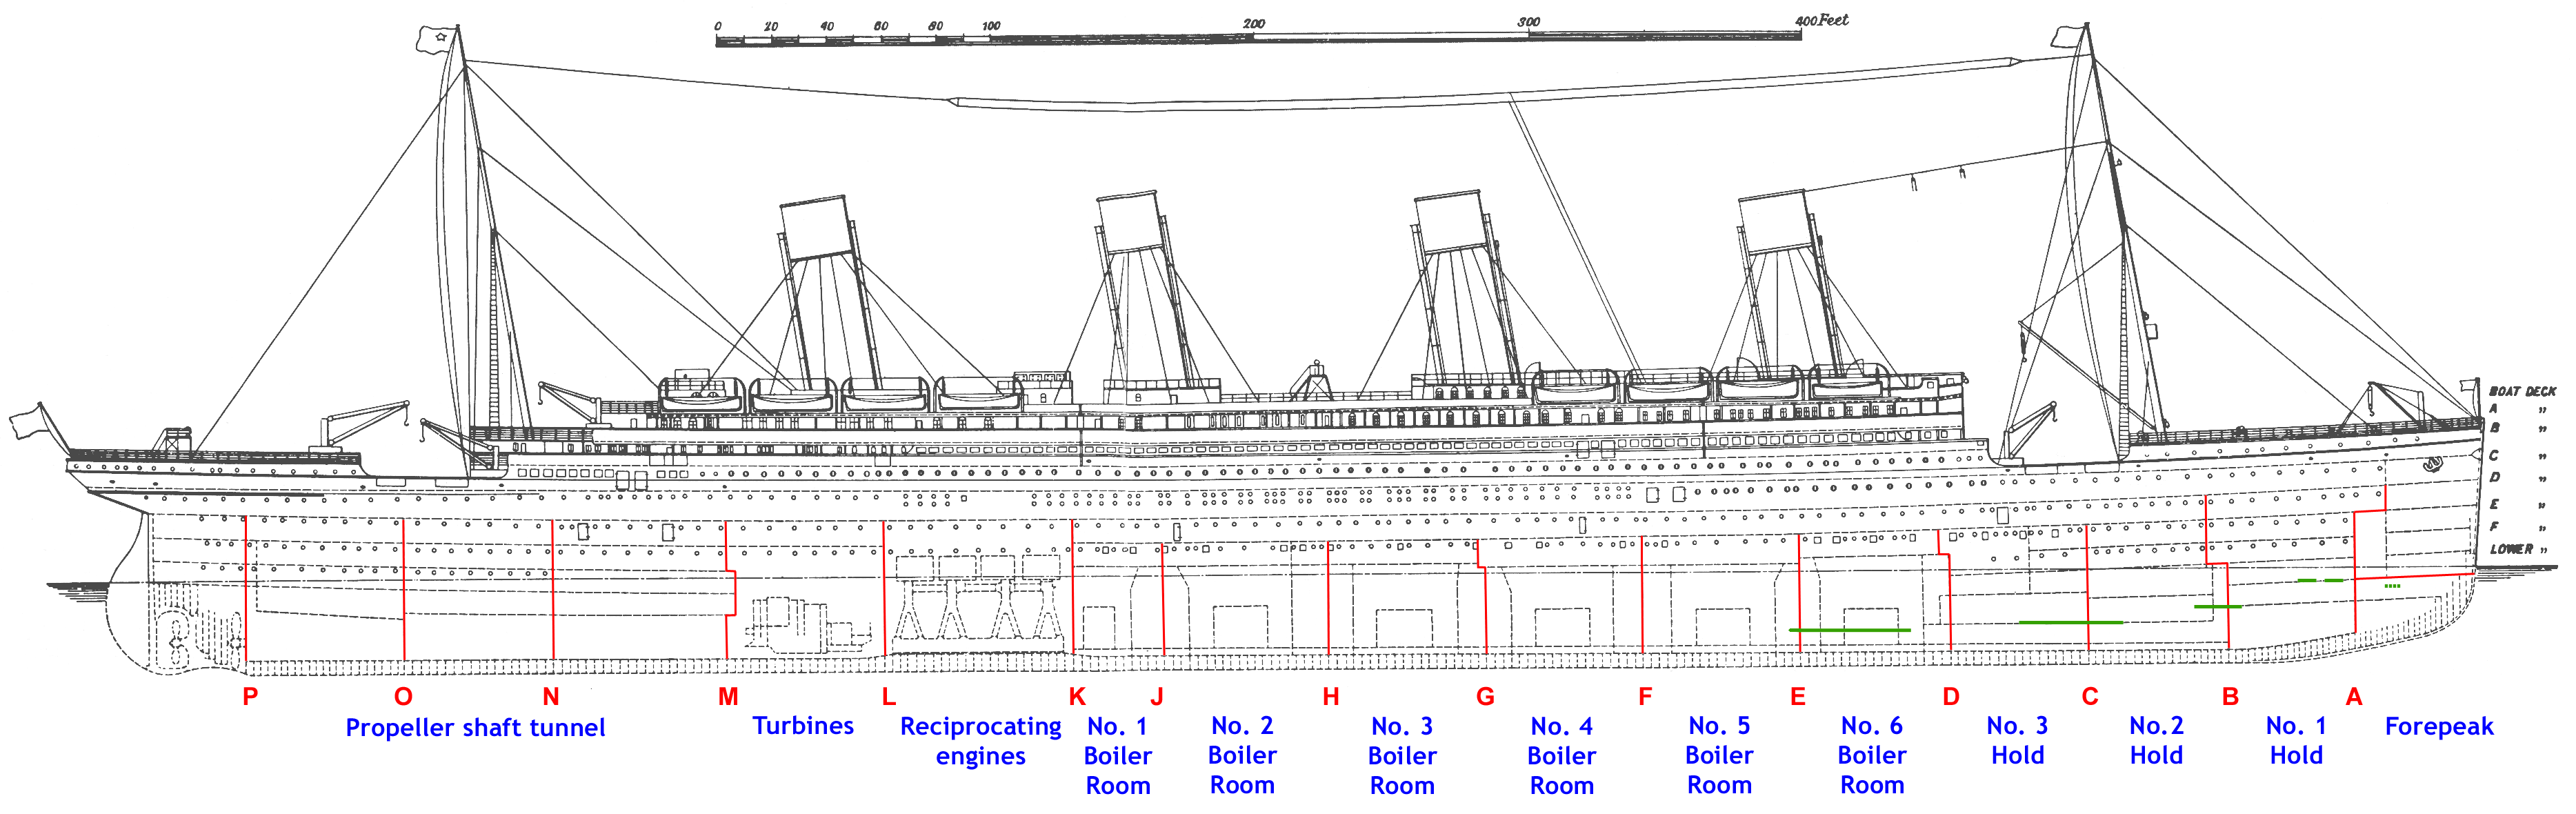

In [517]:
display(Image('https://upload.wikimedia.org/wikipedia/commons/5/5d/Titanic_side_plan_annotated_English.png'))

The plot shows location of each cabin, area in green are damaged parts caused by collision with the iceberg.  
*[Source: Wikipedia](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic)*

## 2.2 Distinct Values in each Variables

In [518]:
combined.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Summary: 
- There are duplicates in Name, which may implies there're duplicate records for one person, we'll check that later.
- Duplicates in Ticket implies there are people in groups who boarded with one ticket. Further investigation tells us the Fare is cumulative for group tickets, we may need to split the fare for those.  
- There are 186 distinct values for Cabin, which is much larger than the actual number of Cabin on Titanic, we'll handle that right after.  


#### Cabin

In [519]:
combined.Cabin.value_counts().head()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
D                  4
F4                 4
Name: Cabin, dtype: int64

The value of Cabin is formed as Cabin + berth or suite number. The effect of berth/suite number on the chance of survuval is nearly impossible to find out. For simplicity we'll focus on Cabin and discard berth/suite number.  
  
#### Ticket

In [520]:
combined.loc[(combined.Parch == 0) & (combined.SibSp == 0), 'Ticket'].value_counts().head()

1601            8
LINE            4
PC 17760        4
S.O.C. 14879    4
C 4001          3
Name: Ticket, dtype: int64

Beside families travelling together, there are many group of passengers boarded with one ticket. This may lead to difficulty calculating split fare for each members if people in one group is separated in training and testing set.  
  
More details about this would be addressed in feature engineering section. 


# 2.3 Spotting Data Inconsistency

### Name
Earlier we saw there're passengers who share same name, let's examine are those duplicate entries or not.

In [521]:
combined.Name.value_counts()[combined.Name.value_counts() > 1]

Connolly, Miss. Kate    2
Kelly, Mr. James        2
Name: Name, dtype: int64

In [522]:
combined.loc[(combined.Name == 'Connolly, Miss. Kate') | (combined.Name == 'Kelly, Mr. James'),:].sort_values('Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
6,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


[The Titanic Encyclopedia](https://www.encyclopedia-titanica.org/titanic-victim/kate-connolly-2.html) tells us there were indeed two Kate Connolly(one should be Catherine), who boarded Titanic as a third class passenger, however the age of the one holding Ticket 330972 is shown to be 41 on the Encyclopedia, not sure which record is correct so I'll leave it at 30.  

There were also two Kelly James who boarded as a third class passenger, though the ages on the website do not align with the result too. 

### Prefix and Sex

In [523]:
# extract prefix from Name
combined['prefix'] = combined.Name.str.extract(r'(\, .*?\.)')
combined['prefix'] = combined.prefix.str.replace('\, ', '')

fem_prefix = ['Miss.', 'Mrs.', 'Mme.', 'Mlle.']
male_prefix = ['Mr.', 'Mister.', 'Master.']

inconsistent_index = []
for i, val in combined.iterrows():
    if val['prefix'] in fem_prefix:
        if val['Sex'] == 'Male':
            inconsistent_index.append(i)
    elif val['prefix'] in male_prefix:
        if val['Sex'] == 'Female':
            inconsistent_index.append(i)

print('Number of Prefix and Sex inconsistency: {}'.format(len(inconsistent_index)))

Number of Prefix and Sex inconsistency: 0


### Parch Size 

Accroding to the definition given by Kaggle, Parch is the total number of parents + children on board, it's fair to assume that for passenger under age of 17, this number should always be less than 2.

In [524]:
combined[(combined.Parch > 2) & (combined.Age <= 17)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix
86,87,0.0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S,Mr.


There is only one such passenger, a little research on the [Encyclopedia](https://www.encyclopedia-titanica.org/titanic-victim/neal-thomas-ford.html) shows there were 4 Fords travelling together:
- [Miss Dollina Margaret Ford](https://www.encyclopedia-titanica.org/titanic-victim/dollina-margaret-ford.html) (Sister)
- [Mr Edward Watson Ford](https://www.encyclopedia-titanica.org/titanic-victim/edward-watson-ford.html) (Brother)
- [Miss Robina Maggie Ford](https://www.encyclopedia-titanica.org/titanic-victim/robina-maggie-ford.html) (Sister)
- [Mrs Margaret Ann Watson Ford](https://www.encyclopedia-titanica.org/titanic-victim/margaret-ann-watson-ford.html) (Mother)

So it appears that the values of SibSp and Parch is swapped, let's correct that.

In [525]:
combined.loc[(combined.Parch > 2) & (combined.Age <= 17), ['SibSp', 'Parch']] = [3, 1]

Let's further investigate these values for the orther Fords:

In [526]:
Fords = ['Ford, Mr. William Neal', 'Ford, Miss. Robina Maggie "Ruby"', 'Ford, Miss. Doolina Margaret "Daisy"', 'Ford, Mrs. Edward (Margaret Ann Watson)', 'Ford, Mr. Edward Watson']

combined.loc[combined.Name.isin(Fords)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix
86,87,0.0,3,"Ford, Mr. William Neal",male,16.0,3,1,W./C. 6608,34.375,NaN,S,Mr.
147,148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.375,NaN,S,Miss.
436,437,0.0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.375,NaN,S,Miss.
736,737,0.0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S,Mrs.
167,1059,NaN,3,"Ford, Mr. Edward Watson",male,18.0,2,2,W./C. 6608,34.375,NaN,S,Mr.


Turns out the numbers are all wrong for siblings of William, let's correct them.  
Be noted that Mrs Margaret Ann Watson Ford is actually travelling with a sibling [Elizabeth Johnston](https://www.encyclopedia-titanica.org/titanic-victim/eliza-johnston.html).

In [527]:
sibs = ['Ford, Miss. Robina Maggie "Ruby"', 'Ford, Miss. Doolina Margaret "Daisy"', 'Ford, Mr. Edward Watson']

combined.loc[combined.Name.isin(sibs), ['SibSp', 'Parch']] = [3, 1]

## 2.4 Identifying Outliers

### Age

Looks Fine.

In [528]:
combined.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

### Fare 

It's not clear why for some passengers fare price is 0. We'll investigate this.

In [529]:
combined.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [530]:
combined[combined.Fare == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Mr.
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,Mr.
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Mr.
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,Mr.
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Mr.
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,Mr.
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,Mr.
481,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,Mr.
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Mr.
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,Mr.


Noticed that these passengers with Fare = 0 all embarked at Southampton, which is where Titanic set sail. A little a Googling tells us:  
-  Some of them are Titanic workers
-  Some of them are the people who runs the company of Titinic and their relatives, for example Joseph Bruce Ismay is the chairman of the company  

So it's safe to assume these 0s are legit, they are people who actually got a free ride. However, the survival rate of crew members is likely to be significant different than passengers, so we can consider leaving these people out of our model.

In [531]:
combined[['Survived', 'Pclass', 'Name', 'Fare', 'Cabin', 'Ticket']].sort_values('Fare', ascending = False).head(20)

,Survived,Pclass,Name,Fare,Cabin,Ticket
258,1.0,1,"Ward, Miss. Anna",512.3292,NaN,PC 17755
679,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",512.3292,B51 B53 B55,PC 17755
343,NaN,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",512.3292,B51 B53 B55,PC 17755
737,1.0,1,"Lesurer, Mr. Gustave J",512.3292,B101,PC 17755
341,1.0,1,"Fortune, Miss. Alice Elizabeth",263.0000,C23 C25 C27,19950
53,NaN,1,"Fortune, Miss. Ethel Flora",263.0000,C23 C25 C27,19950
27,0.0,1,"Fortune, Mr. Charles Alexander",263.0000,C23 C25 C27,19950
88,1.0,1,"Fortune, Miss. Mabel Helen",263.0000,C23 C25 C27,19950
438,0.0,1,"Fortune, Mr. Mark",263.0000,C23 C25 C27,19950
69,NaN,1,"Fortune, Mrs. Mark (Mary McDougald)",263.0000,C23 C25 C27,19950


Sorted by fare price, we see the top 4 values of fare belongs to 4 groups of 1st-class passengers, therefore the high price makes sense.

## 2.5 Feature Engineering
*Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques.*.  - Wikipedia  

By the definition above, feature engineering should be a dynamic process and ideas of new features come up as we get more familar with the data. Normally this process is involved in EDA, but I decided to put feature engineering as a stand-alone section in order to keep the stucture of this article straightforward. 

### Prefix 
In previous section we see Name variable contains prefix information, that could be one useful features to add.  

In [532]:
# extract prefix from Name
combined['prefix'] = combined.Name.str.extract(r'(\, .*?\.)')
combined['prefix'] = combined.prefix.str.replace('\, ', '')

combined.prefix.value_counts()

Mr.              757
Miss.            260
Mrs.             197
Master.           61
Rev.               8
Dr.                8
Col.               4
Major.             2
Ms.                2
Mlle.              2
Dona.              1
Jonkheer.          1
the Countess.      1
Capt.              1
Sir.               1
Mme.               1
Don.               1
Lady.              1
Name: prefix, dtype: int64

In [533]:
prefix_dict = {
    'Capt.' : 'Officer',
    'Col.' : 'Officer',
    'Don.' : 'Royalty',
    'Dona.' : 'Royalty',
    'Dr.' : 'Officer',
    'Jonkheer.' : 'Royalty',
    'Lady.' : 'Royalty',
    'Major.' : 'Officer',
    'Master.' : 'Master',
    'Miss.' : 'Miss',
    'Mlle.' : 'Miss',
    'Mme.' : 'Miss',
    'Mr.' : 'Mr',
    'Mrs.' : 'Mrs',
    'Ms.' : 'Mrs',
    'Rev.' : 'Officer',
    'Sir.' : 'Royalty',
    'the Countess.' : 'Royalty'
}

combined.prefix = combined.prefix.apply(lambda row: prefix_dict[row])

Some rarely seen prefixes were combined together, the variable was reduced to have 6 distinct values, they were distributed as follows:

In [534]:
combined.prefix.value_counts()

Mr         757
Miss       263
Mrs        199
Master      61
Officer     23
Royalty      6
Name: prefix, dtype: int64

### Cabin  

In order to get a brighter sense of how cabin imapcts survival and interacts with other variables, missing values were coded 'M'.  

In [535]:
# Deck of cabin
# 'M' represents missing
combined.Cabin = combined.Cabin.apply(lambda row: row[0] if pd.notnull(row) else 'M')

combined.Cabin.value_counts()

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

### logFare  

Fare was taken log with base 10 to produce logFare, taking log of skewed continuous variables reduces the dynamic range, makes large difference in the variable comparable meanwhile preserving the differences between the values. Note that Fare was added by 1 beofore taken log, this is because there are 0s in Fare which goes to negative infinity, which is not desired. Adding 1 has little effect to the log values while preventing the value to explode.

We'll see wheter this is a good transformation later.

In [536]:
combined['logFare'] = np.log10(combined.Fare + 1)

### FamilySize

It's intuitive to combine parch, sibling, and spouse to create a FamiliSize variable.

In [537]:
combined['FamilySize'] = combined.Parch + combined.SibSp

### noFamily

Create a binary variable indicates wheter the passenger travel with family members

In [538]:
combined['noFamily'] = combined.apply(lambda row: 1 if row['FamilySize'] == 0 else 0, axis=1)

Train test split so we preserve the variables we added.

In [539]:
# split into train/test with new variable
train = combined.iloc[:891,:]
test = combined.iloc[891:,:]

### SplitFare

I want to spend some paragraphs to talk about wheter we can calculate splitFare for passengers that travel together. Earlier we saw that there were non-family passengers who travel together, let's see how many of them were separated by training and testing set.

In [540]:
tickets = set()
for ticket in train.Ticket:
    tickets.add(ticket)

ind = 0
for ticket in test.Ticket:
    if ticket in tickets:
        ind += 1
    else:
        tickets.add(ticket)

nonfam_tickets = set()
ind_2 = 0
for ticket in train.loc[train.noFamily == 1, 'Ticket']:
    nonfam_tickets.add(ticket)

for ticket in test.loc[test.noFamily == 1, 'Ticket']:
    if ticket in nonfam_tickets:
        ind_2 += 1
    else:
        nonfam_tickets.add(ticket)
        
print('{} group tickets out of {} tickets show up in both training and testing set, \n among them, {} were from families and {} were not.'.format(ind, len(tickets), ind - ind_2, ind_2))

170 group tickets out of 929 tickets show up in both training and testing set, 
 among them, 143 were from families and 27 were not.


### Data Leakage - Why I chose not to calculate SplitFare

SplitFare for families can be easily calculated even if family members span across training and testing data set, because family size information was given for every passenger.

What about those 23 non-family groups? I've seen a lot of kernel on Kaggle which combine training and testing set, group passengers by ticket, then divide Fare by group size. **This should never happen in real world machine learning problem**, more precisely, you cannot make it happens.  

The reason why we use a testing set to evaluate model accuracy is to see how well the model perform on data it hasn't seen before, if any information from the testing set enter the training set(in this case the ticket information), it's considered data leakage. By doing so, you're forcing you're model to adapt for your testing set(even the slightest tweak), or in other words, you model is over-fitting on your testing set. 

Another reason why avoiding data leakage is important, you would not be able to obtain the same information if given another set of testing data. Imagine your model is used to predict survival for a unseen passenger that's not in the testing set, how do you now whether he/she was travelling in group that's not formed by family members?

Yes, I know accuracy matters the most in Kaggle, and people use information from testing set to boost their scores, but since Titanic is usually a starting project for biginers and Kaggle new-comvers, it's important to bring out this concept to them and spread awareness that this should not happen in production.  

For more information on data leakage, refer to [this page](https://www.kaggle.com/alexisbcook/data-leakage).

# 2.6 Survival Rate in Training Set

Survival rate in training set: 0.38


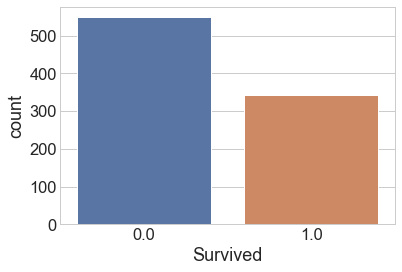

In [541]:
print('Survival rate in training set: {}'.format(round(train.Survived.mean(), 2)))
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
sns.countplot(train.Survived)

Titanic problem is a **binary classification** problem, you're classifying passenger into two group, survived and perished. It's crucial that you identify the ratio of two groups in the training set for this kind of problem.  

But Why?  

Imaging in your training set, 99% of passengers survived, then by simply predict all passenger to survive, you'll get 99% of training accuracy. We call this **imbalanced classes**. A lot of machine learning problem suffers from imbalanced data in natural, for example detecting frauds from bank transactions, naturally there would be only a few frauds among a million of transactions. There're many ways to tackle imbalance in the data. See more [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).  

So we have about 38% of passengers survived in the training set, which is good because we know the true survival rate for passengers is 38%. We don't need to worry about imbalanced class in this problem.

# 2.7 A Closer Look at Each Variable and How They Affect Survival

### Important Note about Cabin

- Missing vlaues in Cabin were replace by 'M' 
- One first class passenger was in Cabin 'T', not sure what it means. Since the information I gathered on the Internet shows no presence of Cabin T, that value was replaced by C cause C has the most people from class 1

In [542]:
# 'M' represents missing
combined.Cabin = combined.Cabin.apply(lambda row: row[0] if pd.notnull(row) else 'M')

# T only consists of 1 passenger and is from class1
# replace cabin T with C cause C has the most people from class 1
combined.loc[combined.Cabin == 'T', 'Cabin'] = 'C'

### Frequency of Values in Each Variable

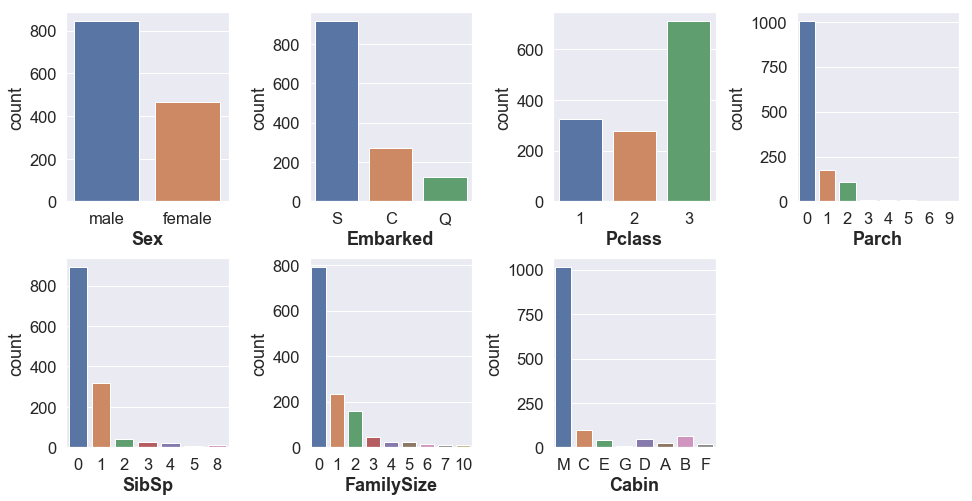

In [543]:
cate_variables = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', 'FamilySize', 'Cabin']

def cate_countplot(data, var_list, cols=4, width=16, height=8, hspace=0.3, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(len(var_list) / cols)
    
    for i, var in enumerate(var_list):
        ax = fig.add_subplot(rows, cols, i+1)
        sns.countplot(var, data=data)
        plt.xlabel(var, weight='bold')
        
cate_countplot(data=combined, var_list=cate_variables)

Summary: 
- Number of male passengers were nearly the double of female passengers  
- Most people embarked at Southampton, much more than the other two ports. Note that Titanic set sail from Southamton, then head to Cherbourg and Queenstown consecutively to pick up passengers  
- There were more third class passengers than first and second class. Second class and first class passengers were roughly the same size  
- Most passengers travelled without companion of family  
- Most values in Cabin were missing, we'll look at this further in next section

### How Each Variable Affects Survival

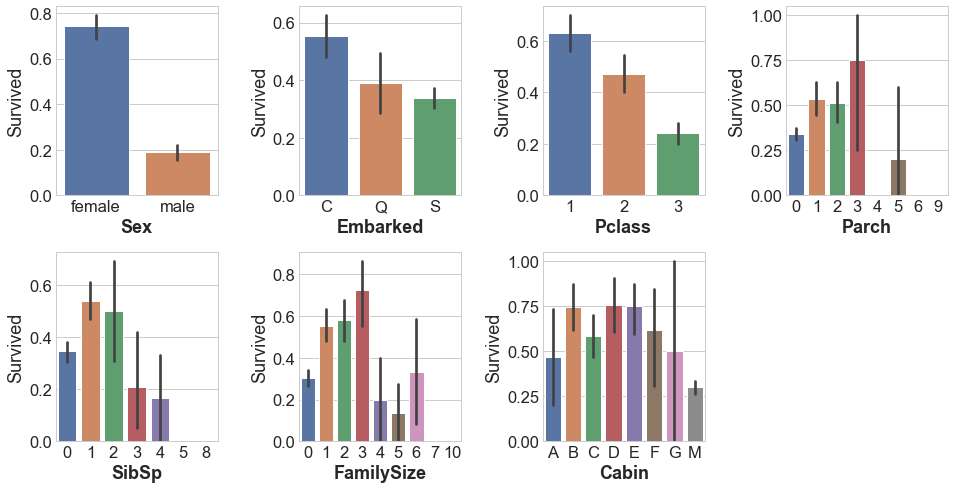

In [544]:
def create_bars(data, variables, cols=4, width=16, height=8, hspace=0.3, wspace=0.5):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(len(variables) / cols)

    for i, column in enumerate(data[variables].columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.barplot(column,'Survived', data=data.sort_values(column))
        plt.xticks(rotation=0)
        plt.xlabel(column, weight='bold')

create_bars(combined, cate_variables)

Summary:
- **Sex**: Female yielded higher chance to survive than male  
- **Pclass**: Not surprisingly, passengers in higher class were more likely to survive  
- **FamilySize**: Survival rate rises with FamilySize at 0 to 3, it encounters a sharp drop at FamilySize = 4 and continues to drop at FamilySize = 5, which too us by surprise  
- **Cabin**: Passengers missing Cabin information have lower chance to survive in general
- **Cabin**: Less than 50% of passengers in Cabin A, G survivied, while passengers in Cabin B, D, E have roughly the same survival rate

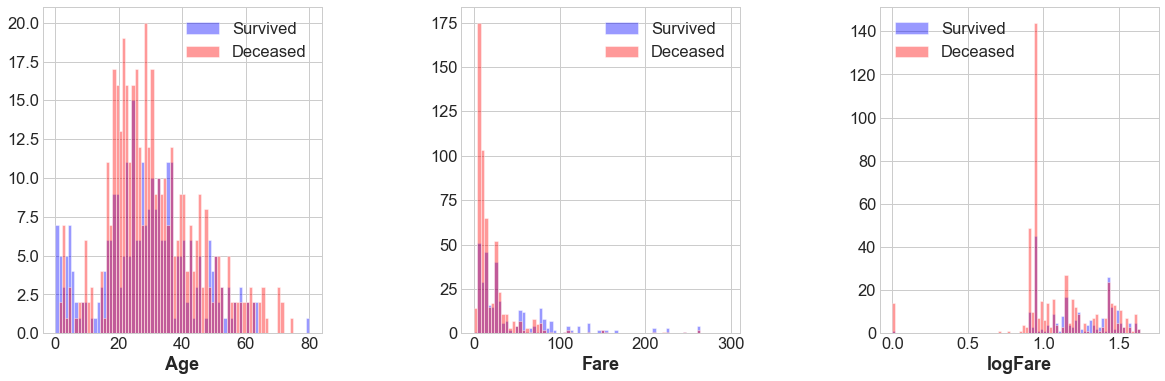

In [545]:
# survival rate on different features
# numerical variables
num_variables = ['Age', 'Fare', 'logFare']

# you are encouraged to play around with the bins and see the effect on plots
bins = [range(0, 81, 1), range(0, 300, 4), np.arange(0, 1.7, 0.02)]
def create_hists(data, variables, bins = bins, cols=3, width=20, height=6, hspace=0.5, wspace=0.5):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(variables) / cols)
    
    survived = data[data['Survived'] == 1]
    passed = data[data['Survived'] == 0]

    for i, column in enumerate(data[variables].columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.distplot(survived[column].dropna(), bins = bins[i], kde = False, color = 'blue')
        sns.distplot(passed[column].dropna(), bins = bins[i], kde = False, color = 'red')
        plt.xticks(rotation=0)
        plt.xlabel(column, weight='bold')
        plt.legend(['Survived', 'Deceased'])
        
create_hists(combined, num_variables)

Summary: 
- **Age**: Children under the age of 15 yielded a significant higher chance to survive. 
- **Age**: People in their middle age are more likely to perish
- **Age**: Seems like people in their 50s have higher chance to survive, but those older are more likely to perished
- **Fare**: Lower fare gives lower survival rate, the effect of fare on survival rate is vague when it comes to a higher level of fare
- **Fare**: Nearly all of those who did not pay perished, this might be telling us that they should be excludes from the model

# 2.8 Exploring Relationship between Variables

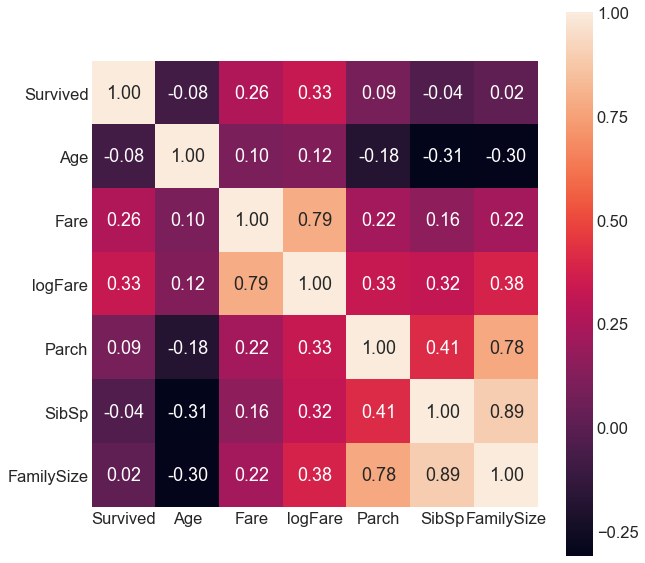

In [546]:
variables_list = ['Survived', 'Age', 'Fare', 'logFare', 'Parch', 'SibSp', 'FamilySize']

plt.figure(figsize=(10, 10))
sns.heatmap(combined.iloc[:891,][variables_list].corr(), annot=True, fmt='.2f', square=True)

Summary:  
- **Fare** and **logFare** both have positive correlaiton with Survivied, but **logFare** is higher, which may imply that **logFare** is a better predictor than **Fare**
- Negative correlations betweem **Age** and **Parch**, **SibSp**, and **FamilySize** are observed. Since larger families are more likely to carry children with them so this make sense
- Sharing ticket and cumulative fare lead to positive correlation between **Fare**/**logFare** with **Familysize** 

### Between Pclass, Sex and Age

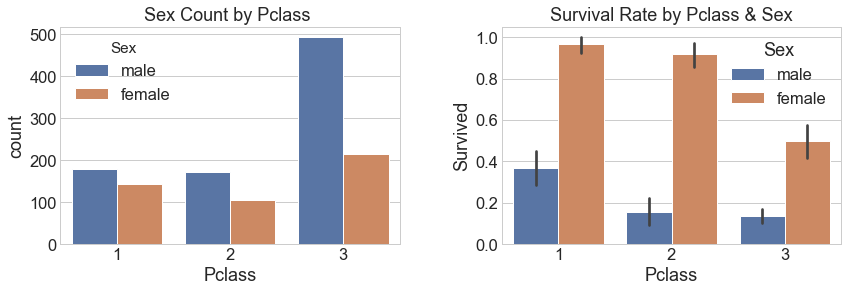

In [547]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(wspace=0.3, hspace=0.5)
ax = fig.add_subplot(1, 2, 1)
sns.countplot(combined.Pclass, hue=combined.Sex)
plt.title('Sex Count by Pclass ')

ax = fig.add_subplot(1, 2, 2)
sns.barplot(x=train.Pclass, y=train.Survived, hue=train.Sex)
plt.legend(title = 'Sex', loc='upper right')
t = plt.title('Survival Rate by Pclass & Sex')

Summary: 
- Pclass 3 was dominant by male, while there were roughly same size of male and female in Pclass 1
- In every class, male passengers yielded significant lower chance to survive than female
- Earlier we discovered that higher class passengers have a higher chance to survive, this pattern applies to both male and female passengers

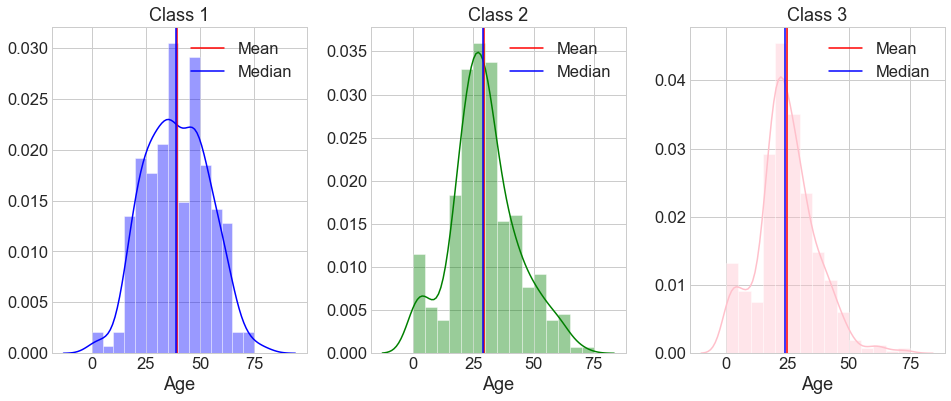

In [548]:
class_list = [1, 2, 3]
def age_dists_by_class(data, class_list, cols=3, width=16, height=6, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(class_list) / cols)
    
    colors = ['blue', 'green', 'pink']
    bins = range(0, 80, 5)
    for i, cls in enumerate(class_list):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.distplot(data[(data.Age.notnull()) & (data.Pclass == cls)].Age, bins=bins, color=colors[i])
        plt.axvline(data[data.Pclass == cls].Age.mean(), color = 'red', label='Mean')
        plt.axvline(data[data.Pclass == cls].Age.median(), color = 'blue', label='Median')
        plt.legend(loc='upper right')
        plt.title('Class {}'.format(str(cls)))

age_dists_by_class(combined, class_list)

Summary:
- 1st class passengers are older on average, most people were at 20 - 65
- 2nd and 3rd class have less elder people but more children
- Young adults domimnated 2nd and 3rd class

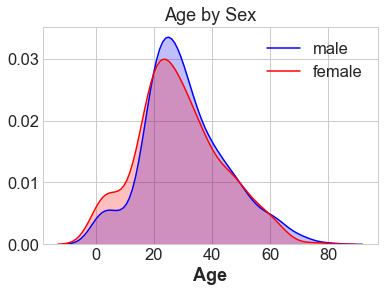

In [549]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
sns.kdeplot(combined.loc[combined.Sex == 'male', 'Age'].dropna(), color='blue', label = 'male',shade=True)
sns.kdeplot(combined.loc[combined.Sex == 'female', 'Age'].dropna(), color='red', label = 'female', shade=True)
plt.xlabel('Age', weight='bold')
t = plt.title('Age by Sex')

The distribution of **Age** in both **Sex** are nearly identical, the predictive power of these two variables are distinguishable from each other.

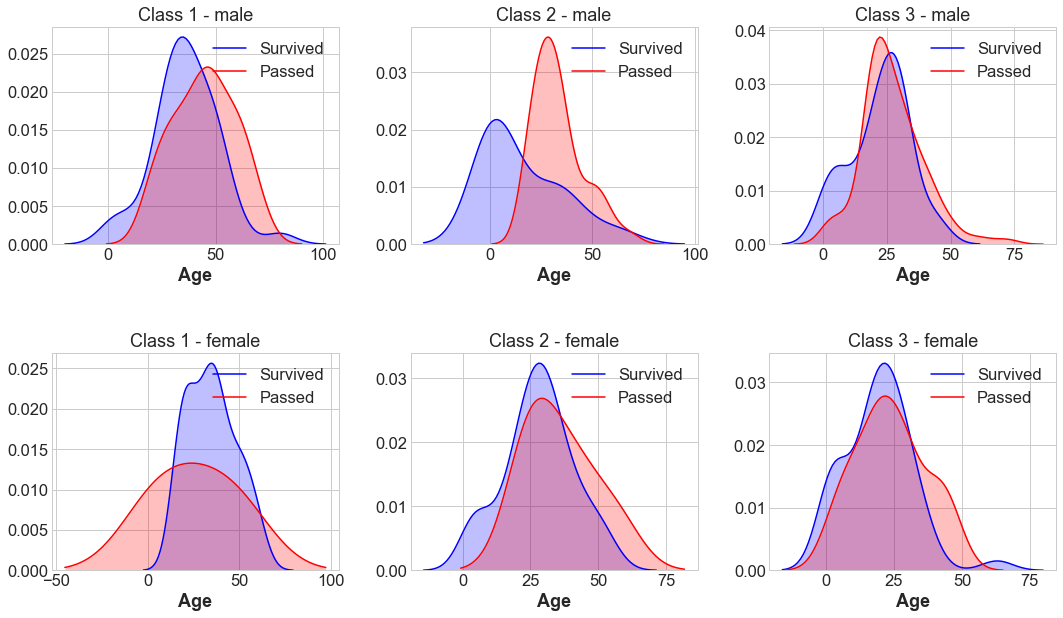

In [550]:
# sex_age_vs_class
sex_list = ['male', 'female']
def sex_age_by_class(data, sex_list, cols=3, width=18, height=10, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(sex_list) * 2 / cols)
    
    survived = data[data.Survived == 1]
    passed = data[data.Survived == 0]
    
    ind = 1
    for i, sex in enumerate(sex_list):
        for j, cls in enumerate([1, 2, 3]):
            ax = fig.add_subplot(rows, cols, ind)
            sns.kdeplot(survived.loc[(survived.Pclass == cls) & (survived.Sex == sex), 'Age'].dropna(), color='blue', shade=True)
            sns.kdeplot(passed.loc[(passed.Pclass == cls) & (passed.Sex == sex), 'Age'].dropna(), color='red', shade=True)
            plt.legend(['Survived', 'Passed'], loc='upper right')
            plt.xlabel('Age', weight='bold')
            plt.title('Class {} - {}'.format(str(cls), sex))
            ind += 1
        
sex_age_by_class(combined, sex_list)

Summary:
- Age is serving as a pretty good descriminative variable for Survived within each Sex of each Pclass, especially for first class female and second class male
- Being in younger age is advantageous for every group excepy first class female, this is mainly because of the lack of female passenger under 15 in 1st class

### Between Fare, Sex and Pclass

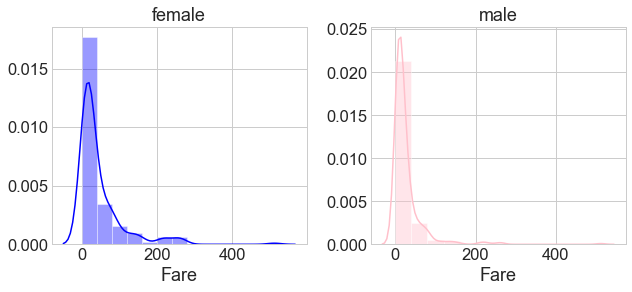

In [551]:
sex_list = ['female', 'male']
def fare_dists_by_sex(data, sex_list, cols=3, width=16, height=4, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(sex_list) / cols)
    
    colors = ['blue', 'pink']
    bins = range(0, 400, 40)
    for i, sex in enumerate(sex_list):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.distplot(data[(data.Fare.notnull()) & (data.Sex == sex)].Fare, bins=bins, color = colors[i])
#         plt.axvline(data[data.Sex == sex].Fare.mean(), color = 'red', label='Mean')
#         plt.axvline(data[data.Sex == sex].Fare.median(), color = 'blue', label='Median')
#         plt.legend(loc='upper right')
        plt.title(str(sex))

fare_dists_by_sex(combined, sex_list)

**male** paid lower Fare on average, this could be justified by the fact that most male were 3rd class passengers while 1st class consisted of more female.

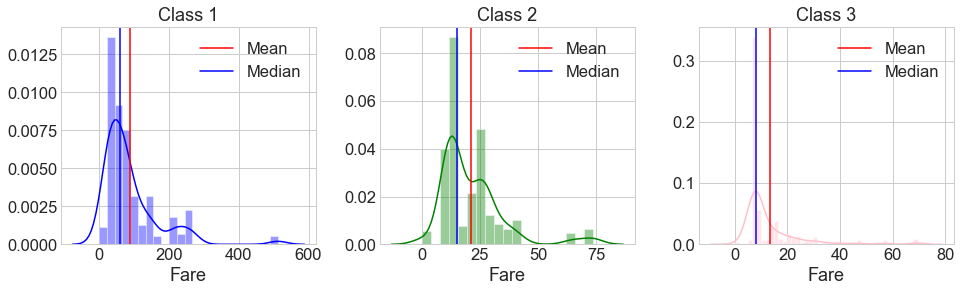

In [552]:
class_list = [1, 2, 3]
def fare_dists_by_class(data, class_list, cols=3, width=16, height=4, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(class_list) / cols)
    
    colors = ['blue', 'green', 'pink']
    
    for i, cls in enumerate(class_list):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.distplot(data[(data.Fare.notnull()) & (data.Pclass == cls)].Fare, color = colors[i])
        plt.axvline(data[data.Pclass == cls].Fare.mean(), color = 'red', label='Mean')
        plt.axvline(data[data.Pclass == cls].Fare.median(), color = 'blue', label='Median')
        plt.legend(loc='upper right')
        plt.title('Class {}'.format(str(cls)))

fare_dists_by_class(combined, class_list)

Matching our expectation, higher class passengers paid higher Fare on average. The distribution of Fare within each class is skewed, so log transformation might be a good idea

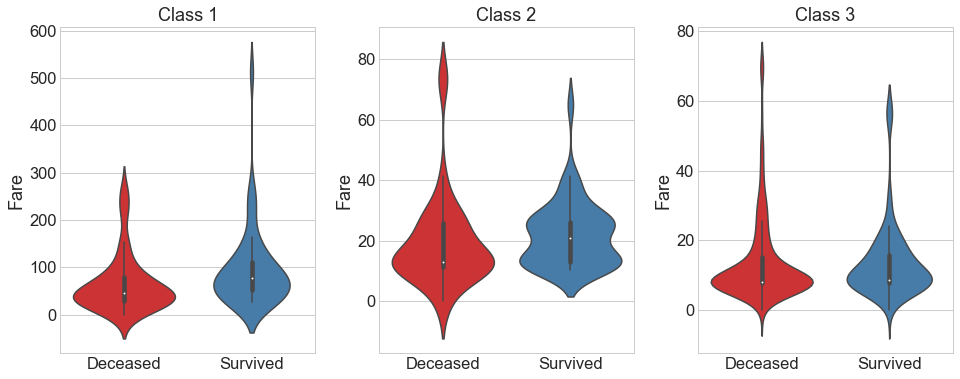

In [553]:
class_list = [1, 2, 3]
def class_violins(data, class_list, cols=3, width=16, height=6, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(class_list) / cols)

    for i, cls in enumerate(class_list):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.violinplot(x='Survived', y='Fare', data=combined[combined.Pclass == cls], palette='Set1')
        plt.title('Class {}'.format(str(cls)))
        ax.set_xticklabels(['Deceased','Survived'])
        plt.xlabel('')

class_violins(combined, class_list)

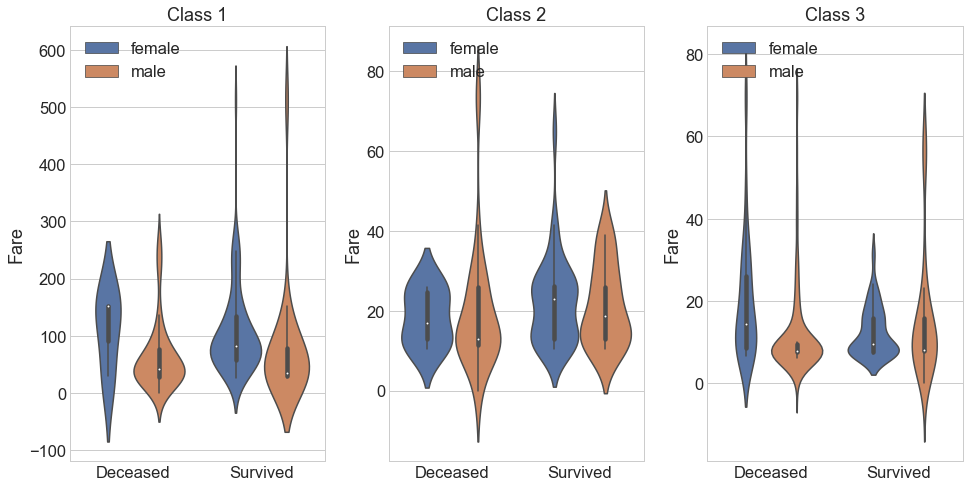

In [554]:
class_list = [1, 2, 3]
def class_violins_by_sex(data, class_list, cols=3, width=16, height=8, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(class_list) / cols)

    for i, cls in enumerate(class_list):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax = sns.violinplot(x='Survived', y='Fare', hue='Sex', data=combined[combined.Pclass == cls].sort_values('Sex'))
        plt.legend(loc='upper left')
        ax.set_xticklabels(['Deceased','Survived'])
        plt.title('Class {}'.format(str(cls)))
        plt.xlabel('')

class_violins_by_sex(combined, class_list)

Summary: 
- Earlier we found that paying a higher fare may increase the chance of survival, this rule looks like it only applies to 1st class.
- In 2nd class, male passengers with the highest Fare tended to perish, while top-paying female tended to survive. This could be viewed as large group of male passengers perished together while female travelling in groups survived together.
- Without calculating split fare for each passengers, the effect of Fare on survival rate is vague

### Is Cabin a Good Variable?

<Figure size 432x288 with 0 Axes>

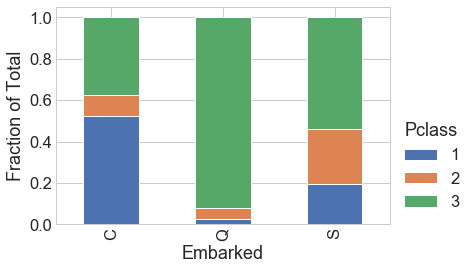

In [555]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
table = pd.crosstab(combined.Embarked, combined.Pclass)
table = pd.crosstab(combined.Embarked, combined.Pclass)
table = table.div(table.sum(axis=1), axis=0)
table.plot(kind="bar", stacked=True)
plt.xlabel('Embarked')
plt.ylabel('Fraction of Total')
plt.legend(title='Pclass', loc='lower right', bbox_to_anchor=(1.25, 0))

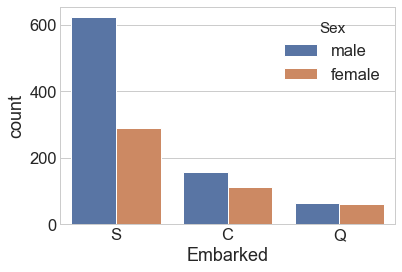

In [556]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
table = pd.crosstab(combined.Embarked, combined.Pclass)
sns.countplot(combined.Embarked, hue=combined.Sex)

It was shown earlier that survival rates for Embarked are C > Q > S, this could be explained by the plots above: 
- Higher proportion of 1st class passengers accounts for higher chance of surviving if embarked at C
- Even though passengers embarked at port Q mostly belonged to 3rd class, it had a fairly balance sex ratio, accounts for higher survival chance than port S
- Large proportion of male embarked at port S lowered the chance of survival

These findings lead to conclusion that Embarked may not provides extra information other than Sex and Pclass.

### Is Cabin a Good Variable?

#### Survival Rate Revisit

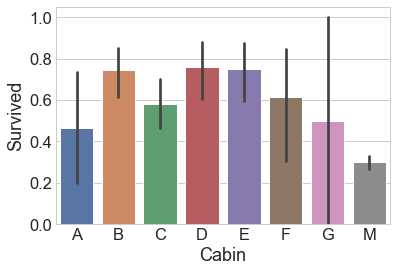

In [557]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
sns.barplot(x='Cabin', y='Survived', data=combined.sort_values(by=['Cabin']))

Pclass   1    2    3
Cabin               
A       22    0    0
B       65    0    0
C       95    0    0
D       40    6    0
E       34    4    3
F        0   13    8
G        0    0    5
M       67  254  693


<Figure size 432x288 with 0 Axes>

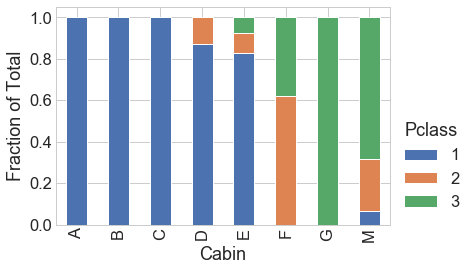

In [558]:
#cabin by class

table = pd.crosstab(combined.Cabin, combined.Pclass)
print(table)
table = table.div(table.sum(axis=1), axis=0)
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
table.plot(kind='bar', stacked=True)
plt.ylabel('Fraction of Total')
plt.legend(title='Pclass', loc='lower right', bbox_to_anchor=(1.25, 0))

Sex    female  male
Cabin              
A           4    18
B          36    29
C          46    49
D          23    23
E          19    22
F           8    13
G           5     0
M         325   689


<Figure size 432x288 with 0 Axes>

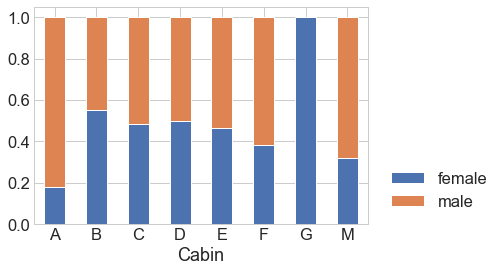

In [559]:
# cabin by sex
table = pd.crosstab(combined.Cabin, combined.Sex)
print(table)
table = table.div(table.sum(axis=1), axis=0)
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(6, 4))
table.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0))

Summary:
- Low survival rate in Cabin A can be explained by large proportion of male in it
- Cabin B to E were almost dominated by 1st class passengers, they also had a balance sex ratio, thus lead to higher chance to survive
- Passengers missing Cabin information were mainly 3rd class passengers, a higher proportion of male passengers can also be observed, these lead to the low survival rate

We may conclude here that, same as Embarked, Cabin provides little to no extra information other than Sex and Pclass.

### Between FamilySize, Pclass and Sex

FamilySize   0    1   2   3   4   5   6   7   10
Pclass                                          
1           160  104  39   9   5   6   0   0   0
2           158   52  45  20   1   1   0   0   0
3           472   79  75  14  16  18  16   8  11


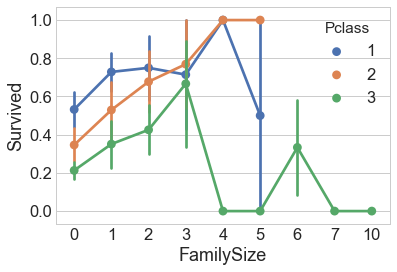

In [560]:
table = pd.crosstab(combined.Pclass, combined.FamilySize)
print(table)
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
sns.pointplot(x='FamilySize', y='Survived', hue='Pclass', data=combined)

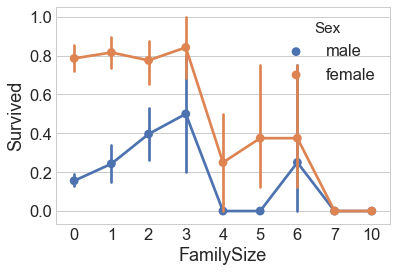

In [561]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=combined)

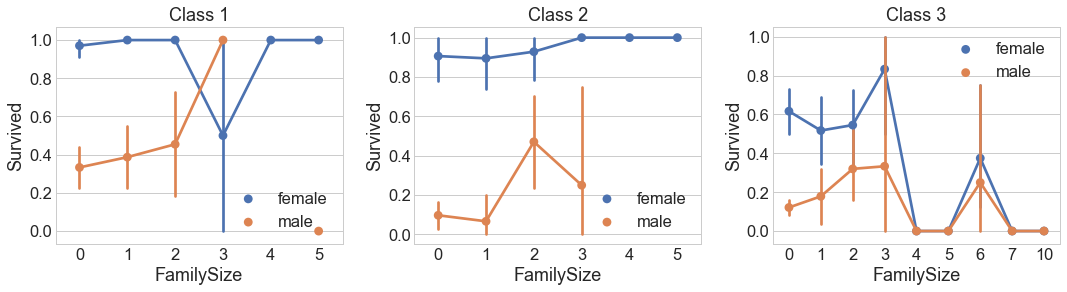

In [562]:
# sex_age_vs_class
def survival_by_class_sex(data, cols=3, width=18, height=4, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = 2

    for i, cls in enumerate([1, 2, 3]):
        ax = fig.add_subplot(1, 3, i+1)
        sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=data[data.Pclass == cls].sort_values('Sex'))
        if i == 2:
            plt.legend(loc='upper right')
        else:
            plt.legend(loc='lower right')
        plt.title('Class {}'.format(str(cls)))
        
survival_by_class_sex(combined, sex_list)

It was shown earlier that having a family of size greater than 4 is disadvantageous:
- This applies to 1st and 3rd class passengers, the effect on 2nd class passengers is unknown because of small sample size
- This also applies to both male and female
- The trend that larger groups under 4 people yield higher trend to survive disappears when looking at each Sex in each Pclass

This implies that adding a binary variable FamilySize > 4 to the model may helps.

# Key Findings from EDA:

- **Age**, **Sex**, **Pclass** are the most important features
- **Age**: **Female** owned a better chance to survive than **male**
- **Fare**: For 1st class passengers, those paid a higher fare(or not travelling alone) had a better chance to survive. For 2nd and 3rd class **male** passengers, those who paid the highest fees(or travelling with large group of people) tended to perished
- **Embarked** seems to not provide extra predictive power to whether a passenger survive on top of Sex and Pclass, same for **Cabin**
- **FamilySize**: Having FamilySize >= 4 decreases the chance for surviving, this applies to all Pclass and both Sex
- **FamilySize**: The trend of 'larger family tends to survive' disappears when data is separated by Sex and Pclass. Implying the trend we observed earlier is only a cross effect of Sex Pclass.

# 3. Missing Values Imputation

### Fare

In [563]:
combined[combined.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix,logFare,FamilySize,noFamily
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,M,S,Mr,NaN,0,1


There was one passenger missing Fare, turns out he's a 3rd class passenger travelling without family members. Let's impute the value by the mean Fare price of 3rd class passengers travelling alone.

In [564]:
F_fill = train[(train.Pclass == 3) & (train.noFamily == 1)].Fare.mean()
combined.loc[combined.Fare.isnull(), 'Fare'] = F_fill
combined.loc[combined.logFare.isnull(), 'logFare'] = np.log(F_fill)

### Embarked

In [565]:
combined[combined.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix,logFare,FamilySize,noFamily
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN,Miss,1.908485,0,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN,Mrs,1.908485,0,1


We know the two passengers missing Embarked information were travelling together because they share the same ticket number. It makes sense to impute the missing Embarked by the most common port in their Pclass/Cabin.

In [566]:
combined.loc[combined.Embarked.isnull(), 'Embarked'] = train[train.Pclass == 3].Embarked.mode()

### Age

Age is the trickiest features to handle in this part. Missing values account for about 20% of this features, we also concluded that Age is one of the most important features, so the chosen method used to fill in those value would impact the model result directly.  

We know that children under 16 yielded a greater chance of survival, so it would be nice if we can spot whether the passenger missing Age information is under that age. Luckily, the title Master, belongs only to children under 16, so let's fill missing Age of Masters with the mean of known Masters age. We'll also use the age mean within each prefix to replace missing values for other passengers.

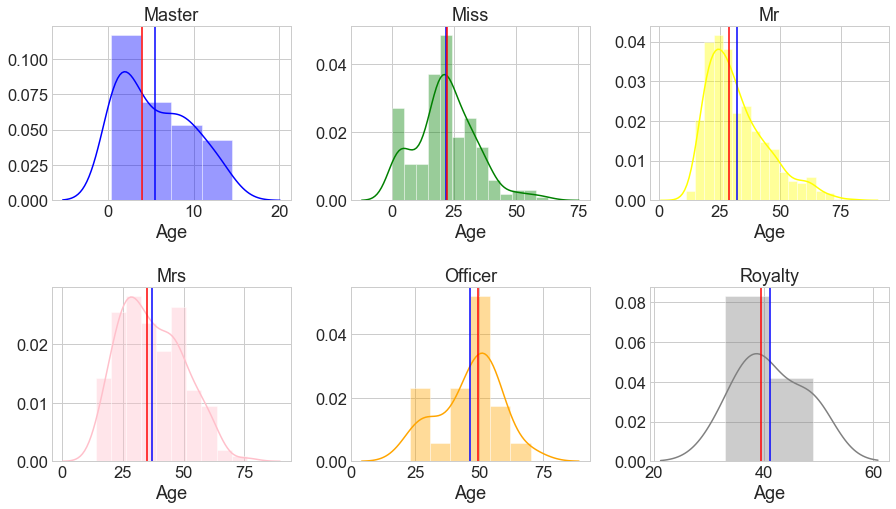

In [567]:
prefix_list = ['Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty']
def hists_by_prefix(data, prefix_list, cols=3, width=15, height=8, hspace=0.5, wspace=0.25):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(prefix_list) / cols)
    
    colors = ['blue', 'green', 'yellow', 'pink', 'orange', 'grey']
    
    for i, prefix in enumerate(prefix_list):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.distplot(data[(data.Age.notnull()) & (data.prefix == prefix)].Age, color = colors[i])
        plt.axvline(data[data.prefix == prefix].Age.mean(), color = 'blue')
        plt.axvline(data[data.prefix == prefix].Age.median(), color = 'red')
        plt.title(prefix)

hists_by_prefix(combined, prefix_list)

In [568]:
# dict of mean for each prefix group
prefix_mean = train.groupby('prefix').Age.mean().to_dict()

# impute missing age
combined.Age = combined.groupby('prefix').Age.transform(lambda x: x.fillna(x.mean()))

# 4. Data Processing 

Transforming data into appropriate format is crucial for model building.  
First, for categorical features like Pclass, Sex, Title, mapping each level of the features into an integer is required for most of the machine learning algorithm to work with. Two common ways of encoding categorical features are:  
1. **Integer Encoding**: This is mapping each level of the feautre to an integer, for example, male = 1, female = 0. This encoding method may be sufficient when there are natural ordering between each level in your feature, like Pclass in our case.  

2. **One-hot encoding**: Probably the most common encoding method, it's widely used when the levels in a categorical features have no ordinal relationship, like Sex. This method would map each level of the feature to a newly-created binary features, and discard the original feature. Be careful when applying one hot-encoding when there are many level in your feature, adding many binary features to your data set is generally not a good idea, this is called the [curse of dimensionality](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e). In that case, binning some levels of your feature may be a good idea. 


In [569]:
# get_dummies
combined_cate_var = pd.get_dummies(combined[['Cabin', 'Embarked', 'prefix']])

# include Pclass
combined_cate_var['Pclass'] = combined.Pclass
combined_cate_var['noFamily'] = combined.noFamily
combined_cate_var['Sex'] = combined.Sex.map({'male':1, 'female':0})

combined_cate_var.columns

Index(['Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_M', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'prefix_Master', 'prefix_Miss', 'prefix_Mr', 'prefix_Mrs',
       'prefix_Officer', 'prefix_Royalty', 'Pclass', 'noFamily', 'Sex'],
      dtype='object')

Second, standardization of numerical features is recommended in most of the case, this is transforming your features to have mean of 0 and stadard deviation of 1, in other words, allowing your feautures to be on the same scales. This is useful because if you're having, say people's hieght and weight in your list of features, with height in feet and weight in grams. You'll most likely to see height ranging from 5 to 7 feet and weights from 40000 to 100000 grams. In such case, the weight feature is likely to introduce larger errors comparing to height, so your choice of algorithm would focus more on reducing the errors from weight. Bringing numerical features onto the same scale assure equal weight of your features on errors. 

In [570]:
num_list = ['Age', 'SibSp', 'Parch', 'logFare', 'FamilySize']

combined_num = combined[num_list].copy()

combined_num[num_list] = StandardScaler().fit_transform(combined_num[num_list].values)

In [571]:
# combined features
combined_processed = pd.concat([combined_cate_var, combined_num], axis=1)

combined_processed.head(5)

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Embarked_C,Embarked_Q,...,prefix_Officer,prefix_Royalty,Pclass,noFamily,Sex,Age,SibSp,Parch,logFare,FamilySize
0,0,0,0,0,0,0,0,1,0,0,...,0,0,3,0,1,-0.599335,0.474620,-0.443575,-0.898007,0.073352
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0.613602,0.474620,-0.443575,1.340083,0.073352
2,0,0,0,0,0,0,0,1,0,0,...,0,0,3,1,0,-0.296101,-0.479724,-0.443575,-0.816910,-0.558346
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0.386176,0.474620,-0.443575,1.041285,0.073352
4,0,0,0,0,0,0,0,1,0,0,...,0,0,3,1,1,0.386176,-0.479724,-0.443575,-0.802568,-0.558346


In [572]:
# train test split 
x_train = combined_processed.iloc[:891,:]
y_train = combined.iloc[:891,:].Survived

x_test = combined_processed.iloc[891:,:]

# 5. Example Model Building

In this section, I will only focus on random forest model and explore different features combination bacause the purpose of this article is to show how a good, in-depth EDA could help you build success model.  
  
Nine out fo ten times, I choose random forest as my model to go if I want to get a sense of how my features are doing, or when I am in need of a baseline model for examining whether the steps I took help in prediction. 

Random forest is good in this context for three reasons:
- **It non-parametric**, meaning that we make no assumption about the structure of the data. For example, when using linear models, you assume there's a linear relationship between your predictors and target variable, but when the true relationship is different than your assumption, you'll probably get low scores. Random forest is free of that problem.  
- **It gives feautre importance scores**, this gives you a clue of what features are more useful, this is useful when you have many features to select from. Be careful, this importance does not apply to different models, it's only meaninigful to the random forest model with the set of parameters that generated the importance scores. 
- **It handles missing data**. The methods it took may not be appropriate for every case, but it's useful to get a quick sense of your data.  

Now that build a model that explore all the features.

In [573]:
# define model
baseline_model = RandomForestClassifier(random_state=4, n_estimators=100, min_samples_split=15, oob_score=True)

# fit
baseline_model.fit(x_train, y_train)

# feature importance
feature_importances = pd.DataFrame({'Importance Score': baseline_model.feature_importances_}, index=x_train.columns).sort_values(by='Importance Score', ascending=False)

# top 10 features by importance
feature_importances[:10]

,Importance Score
prefix_Mr,0.199132
Sex,0.165730
logFare,0.148299
Age,0.100809
Pclass,0.077416
FamilySize,0.050183
prefix_Miss,0.042655
Cabin_M,0.042329
prefix_Mrs,0.035867
SibSp,0.031913


Let's select up to 10 features using [Recursive Feature Elimination (RFE)](https://machinelearningmastery.com/rfe-feature-selection-in-python/).

In [574]:
rfe = RFE(estimator=baseline_model, n_features_to_select=1, step=1)
rfe.fit(x_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=4, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [575]:
importance = pd.DataFrame()
importance['features'] = x_train.columns.values
importance['ranking'] = rfe.ranking_
importance = importance.sort_values('ranking')

cv_result = pd.DataFrame()
cv_result['num_features'] = range(1, 11, 1)
cv_result['training_score'] = 0
cv_result['testing_score'] = 0
cv_result['testing_std'] = 0

for i in range(1, 11, 1):
    # top features
    features = importance['features'].iloc[:i]
    
    # compute training and CV accuracy
    cv_score = cross_validate(baseline_model, x_train[features], y_train, cv=10, return_train_score=True)
    cv_result.loc[i-1, 'training_score'] = cv_score['train_score'].mean()
    cv_result.loc[i-1, 'testing_score'] = cv_score['test_score'].mean()
    cv_result.loc[i-1, 'testing_std'] = cv_score['test_score'].std()

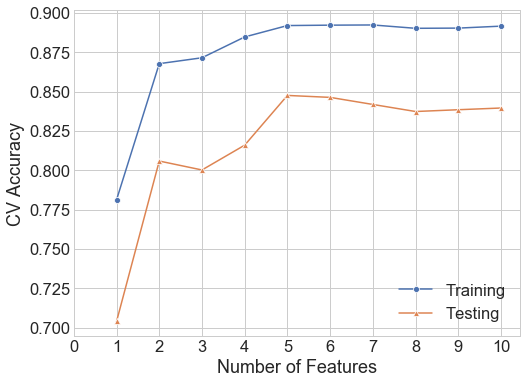

In [576]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(8, 6))
sns.lineplot(cv_result['num_features'], cv_result['training_score'], marker="o", label='Training')
sns.lineplot(cv_result['num_features'], cv_result['testing_score'], marker="^", label='Testing')
t = plt.xticks(range(0, 11, 1))
plt.xlabel('Number of Features')
plt.ylabel('CV Accuracy')
plt.legend()

So including 5 features give us the highest testing CV accuracy, these features are:

In [577]:
importance['features'].iloc[:5]

23      logFare
13    prefix_Mr
19          Sex
20          Age
17       Pclass
Name: features, dtype: object

With these features, let's search for the best paramters using grid-search CV

In [578]:
tree_param_grid = {'max_depth': [10, 20, 30, 40],
 'min_samples_split': [2, 5, 10, 15, 20, 25],
 'n_estimators': [50, 100, 150, 200]}

grid = GridSearchCV(RandomForestClassifier(), param_grid=tree_param_grid, cv=10, n_jobs=-1)
grid.fit(x_train[importance['features'].iloc[:5]], y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40], 'min_samples_split': [2, 5, 10, 15, 20, 25], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [579]:
print('Best CV score {} was achieved with:'.format(round(grid.best_score_, 4)))
params = grid.best_estimator_.get_params()
print('max_depth: {}'.format(str(params['max_depth'])))
print('min_samples_split: {}'.format(str(params['min_samples_split'])))
print('n_estimators: {}'.format(str(params['n_estimators'])))

Best CV score 0.8519 was achieved with:
max_depth: 10
min_samples_split: 5
n_estimators: 150


Fit full model and make prediction

In [580]:
model = RandomForestClassifier(**params)
model.fit(x_train[importance['features'].iloc[:6]], y_train)
prediction = model.predict(x_test[importance['features'].iloc[:6]]).astype(int)
submission = pd.DataFrame(test.PassengerId.copy())
submission['Survived'] = pd.Series(prediction)
submission.to_csv('submission.csv', index = False)

Kaggle score: 0.77511

# 6. Simple Model with Findings from EDA

Let's build a simple model with only the three most important features we found by EDA: **Pclass, Sex, Age** and see how it performs.  

With these features, let's also experiment, see how missing values imputation of Age affect model result.

### 1. Impute with mean

In [581]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# get mean of passenger's age from training set
age_mean = train.Age.mean()

# replace in training set
train.Age = train.apply(lambda row: age_mean if pd.isnull(row['Age']) else row['Age'], axis=1)

# same for testing set
test.Age = test.apply(lambda row: age_mean if pd.isnull(row['Age']) else row['Age'], axis=1)

In [588]:
# define the model
# same model that we use before
baseline_model = RandomForestClassifier(random_state=4, n_estimators=100, min_samples_split=15, oob_score=True)

# separate training and target variables
X = train[['Sex', 'Age', 'Pclass']].copy()
Y = train['Survived']

# encode Sex 
# 0 for female, 1 for male
X.Sex = X.apply(lambda row: 0 if row['Sex'] == 'female' else 1, axis=1)

# fit
baseline_model.fit(X, Y)

print('OOB score of baseline model: {}'.format(round(baseline_model.oob_score_, 3)))

OOB score of baseline model: 0.813


In [583]:
# data processing on test set
test_X = test[['Sex', 'Age', 'Pclass']].copy()
test_X.Sex = test_X.apply(lambda row: 0 if row['Sex'] == 'female' else 1, axis=1)

# make prediction on test data
baseline_prediction = baseline_model.predict(test_X)

# produce csv file for submission
baseline_submission = pd.DataFrame(test.PassengerId.copy())
baseline_submission['Survived'] = pd.Series(baseline_prediction)
baseline_submission.to_csv('baseline_submission.csv', index = False)

Kaggle score: 0.74401

### 2. Impute with Pclass mean

In [584]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combined = train.append(test, sort=False)

In [585]:
class_mean = train.groupby('Pclass').Age.mean().to_dict()

train.Age = train.groupby('Pclass').Age.transform(lambda x: x.fillna(x.mean()))
test.Age = test.apply(lambda row: class_mean[row['Pclass']], axis=1)

X = train[['Sex', 'Age', 'Pclass']].copy()
Y = train['Survived']

# encode Sex 
# 0 for female, 1 for male
X.Sex = X.apply(lambda row: 0 if row['Sex'] == 'female' else 1, axis=1)

# fit
baseline_model.fit(X, Y)

print('OOB score of baseline model: {}'.format(round(baseline_model.oob_score_, 3)))

# data processing on test set
test_X = test[['Sex', 'Age', 'Pclass']].copy()
test_X.Sex = test_X.apply(lambda row: 0 if row['Sex'] == 'female' else 1, axis=1)

# make prediction on test data
baseline_prediction = baseline_model.predict(test_X)

# produce csv file for submission
baseline_submission = pd.DataFrame(test.PassengerId.copy())
baseline_submission['Survived'] = pd.Series(baseline_prediction)
baseline_submission.to_csv('age_by_class_submission.csv', index = False)

OOB score of baseline model: 0.807


Kaggle Score: 0.76555

### 3. Impute with prefix mean

In [589]:
baseline_model.fit(x_train[['Age', 'Sex', 'Pclass']], y_train)
prediction = baseline_model.predict(x_test[['Age', 'Sex', 'Pclass']]).astype(int)
submission = pd.DataFrame(test.PassengerId.copy())
submission['Survived'] = pd.Series(prediction)
submission.to_csv('age_by_prefix_submission.csv', index = False)

Kaggle Score: 0.77511

In [ ]:
# to do:
write conclusion
verify score
